In [5]:
from graphviz import Source
from networkx.drawing.nx_agraph import to_agraph
from networkx.readwrite.gpickle import read_gpickle
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph

#from ete3 import Tree
#from ete3.parser.newick import NewickError

import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error

from glob import glob
import os
import re

import seaborn as sns
import matplotlib.pyplot as plt



sns.set_style('white')
sns.set_context('notebook')

def plot_style(figsize=(12, 6), labelsize=20, titlesize=24, ticklabelsize=14, **kwargs):
   basic_style = {
       'figure.figsize': figsize,
       'axes.labelsize': labelsize,
       'axes.titlesize': titlesize,
       'xtick.labelsize': ticklabelsize,
       'ytick.labelsize': ticklabelsize,
       'axes.spines.top': False,
       'axes.spines.right': False,
       'axes.spines.left': False,
       'axes.grid': False,
       'axes.grid.axis': 'y',
   }
   basic_style.update(kwargs)
   return plt.rc_context(rc=basic_style)

blue = sns.xkcd_rgb['ocean blue']

In [ ]:

def get_root_node(t):
    root_nodes = [n for n,d in t.in_degree() if d==0]
    #print(root_nodes)
    assert len(root_nodes) == 1
    root_node = root_nodes[0]
    return root_node
    

# Converts a networkx graph to newick format
def recursive_newick(tree, node, count):
    successors = list(tree.successors(node))
    if len(successors) == 0:
        cell_id = node
        return f'{cell_id}:{count}'
    elif len(successors) == 1:
        count += 1
        return recursive_newick(tree, successors[0], count)
    else:
        children = []
        for child in successors:
            child_repr = recursive_newick(tree, child, 1)
            children.append(child_repr)
        return '(' + ','.join(children) + f'):{count}'
    
    
# Takes a tree in newick format and generates a distance matrix between leaves based on tree topology.
def compute_distance_matrix(nw):
    tree = Tree(nw)
    leaves = tree.get_leaves()
    leaf_labels = [leaf.name for leaf in leaves]
    
    filtered_leaves = [leaf for leaf in leaves if leaf.name.startswith('s')]
    filtered_leaf_labels = [leaf.name for leaf in filtered_leaves]
    
    distance_matrix = pd.DataFrame(index=filtered_leaf_labels, columns=filtered_leaf_labels)
    for i, node1 in enumerate(filtered_leaves):
        for j, node2 in enumerate(filtered_leaves[i+1:], i+1):
            #distance = node1.get_distance(node2)
            distance = node1.get_distance(node2, topology_only=True)
            distance_matrix.at[filtered_leaf_labels[i], filtered_leaf_labels[j]] = distance
            distance_matrix.at[filtered_leaf_labels[j], filtered_leaf_labels[i]] = distance
    return distance_matrix



# read a .gv file, convert to nw, generate a distance matrix returned as a df
def generate_distance_mx(tree_filename):
    # generate graph
    tree = nx.drawing.nx_pydot.read_dot(tree_filename)
    tree.remove_node('\\n')
    root_node = get_root_node(tree)
    #print(root_node)
    # convert to nw tree
    nw = '(' + recursive_newick(tree, root_node, 1) + ');'
    # Generate the distance matrix
    nw_df = compute_distance_matrix(nw)
    nw_df = nw_df.fillna(0.0)    
    # Remove duplicate columns resulting from multiple edges pointing to the same leaf 
    nw_df = nw_df.T.drop_duplicates(keep='first').T.drop_duplicates(keep='first').T
    return nw_df

def path_len_dist(tree1, tree2): 
    #dist_mat1, dist_mat2 = tree1.dist_matrix, tree2.dist_matrix
    dist_mat1, dist_mat2 = tree1, tree2
    denominator = (dist_mat1.size - dist_mat1.shape[0]) / 2
    return np.sum((dist_mat1 - dist_mat2)**2) / denominator
            

In [9]:
#gt_graph = f'../../../mt-SCITE/mt-SCITE_output/Simulations/ground_truth/tree6_map0.gv'
#gt_graph = f'../../../mt-SCITE/mt-SCITE_output/Simulations/test/MSE/gt/tree5_map0.gv'
#gt_graph = f'../../../mt-SCITE/mt-SCITE_output/Simulations/ground_truth/tree8_map0.gv'
gt_graph = f'../../../mt-SCITE/mt-SCITE_output/Simulations/ground_truth/tree9_map0.gv'

nw_gt_df = generate_distance_mx(gt_graph)

In [52]:
#INPUT_PATH = '../../../mt-SCITE/mt-SCITE_output/Simulations/non-informative_mutations/tree6/tree6_1_iter/8_cells/'
#INPUT_PATH = '../../../mt-SCITE/mt-SCITE_output/Simulations/test/MSE'
#INPUT_PATH = '../../../mt-SCITE/mt-SCITE_output/Simulations/non-informative_mutations/'
#INPUT_PATH = '../../../mt-SCITE/mt-SCITE_output/Simulations/test/add_noise_w_step/tree9_1_iter/8_cells/'

INPUT_PATH = '../../../mt-SCITE/mt-SCITE_output/Simulations/non-informative_mutations/tree9/'


# Get all gv files in the input path
gv_files = list(glob(os.path.join(INPUT_PATH, '*/*/*.gv')))

mses = []
files = []

for filename in sorted(gv_files, key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)]):
    #print(filename)
    name = os.path.basename(filename).split('.')[0].rsplit('_', 3)[0]
    #print(name)
    files.append(name)
    nw_sim_df = generate_distance_mx(filename)
    #mse = np.sqrt(mean_squared_error(nw_sim_df, nw_gt_df))
    mse = mean_squared_error(nw_sim_df, nw_gt_df)
    mses.append(mse)

In [48]:
#mses

In [55]:
mse_df = pd.DataFrame(
    {'tree': files,
     'mse': mses,
    })
mse_df

,tree,mse
0,tree9_2_cells_10_pos,1.4872
1,tree9_2_cells_10_pos,0.2392
2,tree9_2_cells_10_pos,0.5392
3,tree9_2_cells_20_pos,0.0000
4,tree9_2_cells_30_pos,1.0072
...,...,...
9882,tree9_8_cells_120_pos,5.0536
9883,tree9_8_cells_120_pos,5.5728
9884,tree9_8_cells_120_pos,4.9206
9885,tree9_8_cells_120_pos,4.8808


In [56]:
mse_df['ni_pos'] = mse_df['tree'].str.split('_', n = 3).str[3]
mse_df

,tree,mse,ni_pos
0,tree9_2_cells_10_pos,1.4872,10_pos
1,tree9_2_cells_10_pos,0.2392,10_pos
2,tree9_2_cells_10_pos,0.5392,10_pos
3,tree9_2_cells_20_pos,0.0000,20_pos
4,tree9_2_cells_30_pos,1.0072,30_pos
...,...,...,...
9882,tree9_8_cells_120_pos,5.0536,120_pos
9883,tree9_8_cells_120_pos,5.5728,120_pos
9884,tree9_8_cells_120_pos,4.9206,120_pos
9885,tree9_8_cells_120_pos,4.8808,120_pos


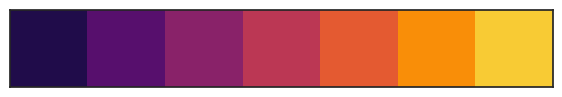

In [118]:
sns.palplot(sns.color_palette('inferno', 7))

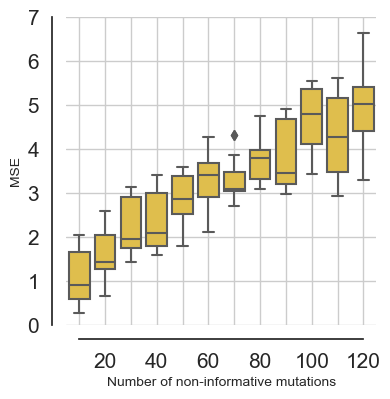

In [178]:
#mupp = mse_df['tree'] == 'tree9_2_cells_10_pos'
#mse_df.loc[~mse_df['tree'].isin('tree9_2_cells')]
plott_data = mse_df[mse_df['tree'].str.contains('tree9_8_cells')]

#labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['', 20, '', 40, '', 60, '', 80, '', 100, '', 120]


#200C4A #58106D #892369 #BC3655 #E45A31 #FA8E09 #F8CB34




with plot_style(figsize=(4, 4), ticklabelsize=10, labelsize=10):
    ax = sns.boxplot(x=plott_data['tree'], y=plott_data['mse'], color = '#F8CB34')
    plt.grid(axis='both')
    ax.set_ylim(0, 7)
    ax.set_xticklabels(labels)

    #sns.boxplot(x="day", y="total_bill", data=tips)
    sns.despine(offset=10, trim=True)
    plt.ylabel('MSE')
    plt.xlabel('Number of non-informative mutations')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    #plt.xticks(rotation = 90)
    plt.savefig(f'../../data/simulated_figures/MSE_8_cells_tree9.pdf', dpi=300, bbox_inches='tight', transparent=True)

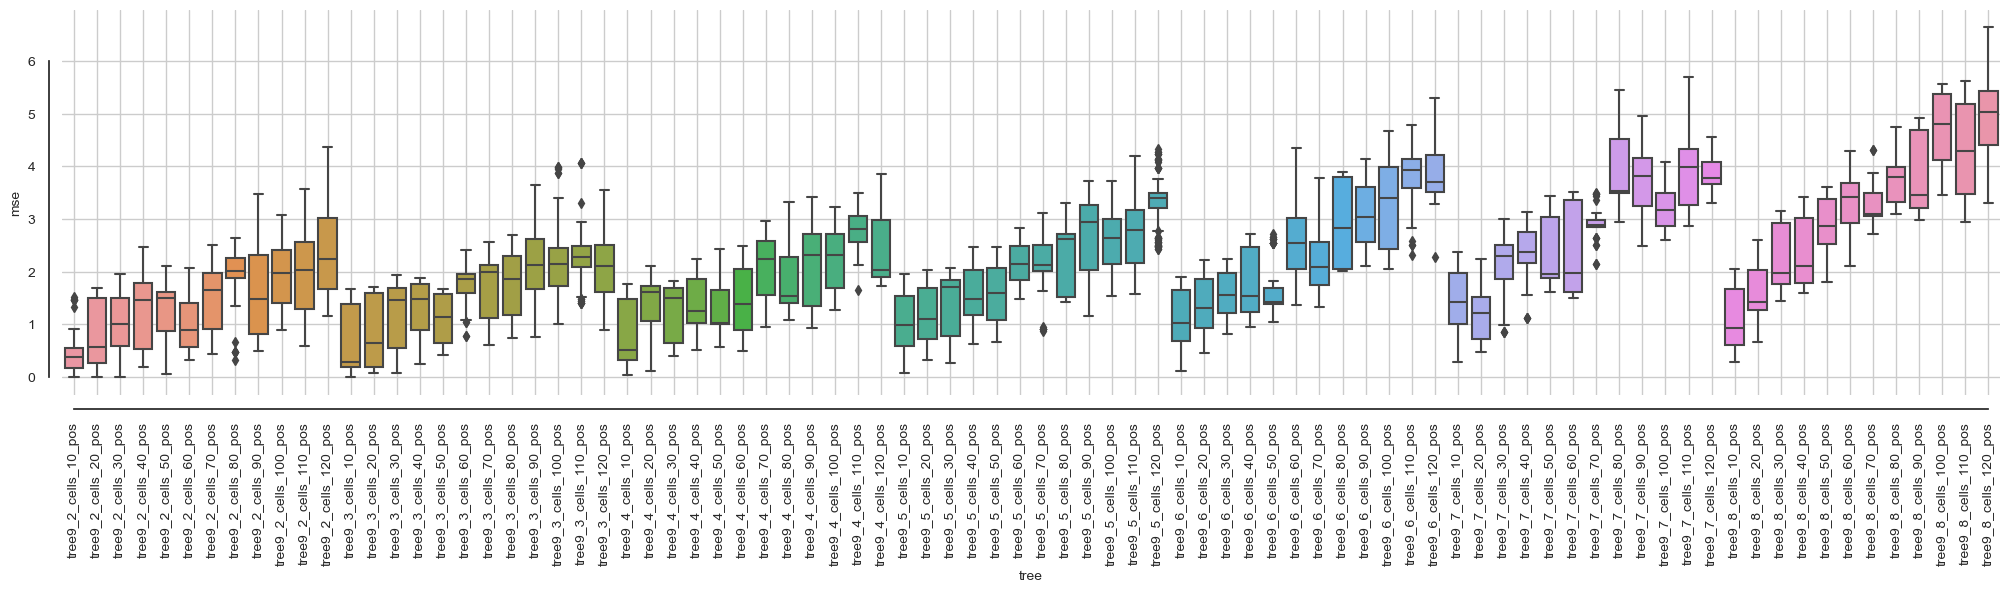

In [105]:
#mse = mean_squared_error(nw_sim_df, nw_gt_df)

with plot_style(figsize=(25, 5), ticklabelsize=10, labelsize=10):
    sns.boxplot(x=mse_df['tree'], y=mse_df['mse'])
    plt.grid(axis='both')

    #sns.boxplot(x="day", y="total_bill", data=tips)
    sns.despine(offset=10, trim=True)
    plt.xticks(rotation = 90)

In [25]:
#data = [10,20,30,40,50,60, 70, 80, 90, 100, 110]

data = [10, 30, 50, 70, 90, 110]
  
df = pd.DataFrame(data, columns=['n_mut'])

df['frac'] = (df['n_mut'] / (df['n_mut'] + 30))*100

In [26]:
df

,n_mut,frac
0,10,25.000000
1,30,50.000000
2,50,62.500000
3,70,70.000000
4,90,75.000000
5,110,78.571429


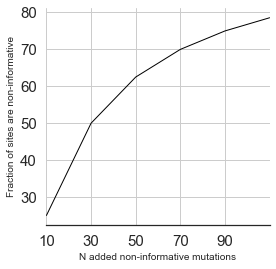

In [29]:
with plot_style(figsize=(4, 4), ticklabelsize=10, labelsize=10):
    ax = sns.lineplot(data=df, x="n_mut", y="frac", lw=1, color='black') #ci=None
    #labels = ['', 20, '', 40, '', 60, '', 80, '', 100, '', 120]
    #labels = [10, '', 30, '', 50, '', 70, '', 90, '', 110]
    #ax.set_ylim(0, 80)
    ax.set_xlim(10, 110)
    plt.grid(axis='both')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.xticks(np.arange(10, 110, step=20))  # Adjust the step value as needed

    
    #tick = 1
    #[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % tick != 0]
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.ylabel('Fraction of sites are non-informative')
    plt.xlabel('N added non-informative mutations')
    
    plt.savefig(f'../../data/simulation_figures/fraction_non-informative.svg', dpi=300, bbox_inches='tight', transparent=True)
    #plt.savefig(f'../../data/simulated_figures/fraction_non-informative.jpg', dpi=300, bbox_inches='tight', transparent=True)